# Data Processing

In [1]:
import pandas as pd
import os
import json
from IPython.display import display
import pyspark
from pyspark.sql import SparkSession
import datetime

clean_path="../data/clean/"
processing_path="../data/processing/"

In [2]:
# Initial Data
_parameters = pd.read_json(clean_path+"parameters.json")
_countries = pd.read_json(clean_path+"countries.json")
_locations = pd.read_json(clean_path+"locations.json")
   
display(_parameters)
display(_countries[_countries['name']=='Spain'])
display(_locations)

for (dirpath, dirnames, filenames) in os.walk(clean_path):
    for filename in filenames:
        if 'measurements' in filename:
            display(pd.read_json(clean_path+filename))

,displayName,name,preferredUnit
0,PM10,pm10,µg/m³
1,PM2.5,pm25,µg/m³
2,O₃ mass,o3,µg/m³
3,CO mass,co,µg/m³
4,NO₂ mass,no2,µg/m³
5,SO₂ mass,so2,µg/m³
6,NO₂,no2,ppm
7,CO,co,ppm
8,SO₂,so2,ppm
9,O₃,o3,ppm


,cities,code,name,parameters
38,59,ES,Spain,"[co, no2, o3, pm1, pm10, pm25, so2, um010, um0..."


,city,country,measurements,name,parameters
0,Lleida,ES,87477,ES1348A,"[{'average': 6.1281787178, 'count': 43689, 'di..."
1,Lleida,ES,158200,ES1225A,"[{'average': 21.8366225906, 'count': 30402, 'd..."
2,Lleida,ES,44096,ES1588A,"[{'average': 31.1434597242, 'count': 44096, 'd..."
3,Lleida,ES,166789,ES1982A,"[{'average': -0.8092838968, 'count': 41265, 'd..."
4,Lleida,ES,87526,ES2034A,"[{'average': 33.592702954800004, 'count': 4396..."
5,Lleida,ES,141226,ES0014R,"[{'average': 52.9704737236, 'count': 46715, 'd..."
6,Lleida,ES,43718,ES1248A,"[{'average': 31.8628253809, 'count': 43718, 'd..."


,location,city,date,parameter,value,unit
0,ES2034A,Lleida,"{'local': '2020-12-30T18:00:00+01:00', 'utc': ...",o3,63,µg/m³
1,ES2034A,Lleida,"{'local': '2020-12-30T18:00:00+01:00', 'utc': ...",no2,4,µg/m³
2,ES2034A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",no2,2,µg/m³
3,ES2034A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",o3,65,µg/m³
4,ES2034A,Lleida,"{'local': '2020-12-30T16:00:00+01:00', 'utc': ...",no2,1,µg/m³
...,...,...,...,...,...,...
19620,ES2034A,Lleida,"{'local': '2019-01-01T13:00:00+01:00', 'utc': ...",o3,10,µg/m³
19621,ES2034A,Lleida,"{'local': '2019-01-01T12:00:00+01:00', 'utc': ...",no2,14,µg/m³
19622,ES2034A,Lleida,"{'local': '2019-01-01T12:00:00+01:00', 'utc': ...",o3,11,µg/m³
19623,ES2034A,Lleida,"{'local': '2019-01-01T11:00:00+01:00', 'utc': ...",no2,9,µg/m³


,location,city,date,parameter,value,unit
0,ES1348A,Lleida,"{'local': '2020-12-30T16:00:00-01:00', 'utc': ...",o3,65,µg/m³
1,ES1348A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",no2,3,µg/m³
2,ES1348A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",o3,70,µg/m³
3,ES1348A,Lleida,"{'local': '2020-12-30T14:00:00-01:00', 'utc': ...",no2,4,µg/m³
4,ES1348A,Lleida,"{'local': '2020-12-30T14:00:00-01:00', 'utc': ...",o3,70,µg/m³
...,...,...,...,...,...,...
19623,ES1348A,Lleida,"{'local': '2019-01-01T11:00:00-01:00', 'utc': ...",no2,14,µg/m³
19624,ES1348A,Lleida,"{'local': '2019-01-01T10:00:00-01:00', 'utc': ...",no2,18,µg/m³
19625,ES1348A,Lleida,"{'local': '2019-01-01T10:00:00-01:00', 'utc': ...",o3,38,µg/m³
19626,ES1348A,Lleida,"{'local': '2019-01-01T09:00:00-01:00', 'utc': ...",no2,24,µg/m³


,location,city,date,parameter,value,unit
0,ES1588A,Lleida,"{'local': '2020-12-30T18:00:00+01:00', 'utc': ...",o3,43,µg/m³
1,ES1588A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",o3,52,µg/m³
2,ES1588A,Lleida,"{'local': '2020-12-30T16:00:00+01:00', 'utc': ...",o3,52,µg/m³
3,ES1588A,Lleida,"{'local': '2020-12-30T15:00:00+01:00', 'utc': ...",o3,55,µg/m³
4,ES1588A,Lleida,"{'local': '2020-12-30T14:00:00+01:00', 'utc': ...",o3,51,µg/m³
...,...,...,...,...,...,...
9848,ES1588A,Lleida,"{'local': '2019-01-01T15:00:00+01:00', 'utc': ...",o3,18,µg/m³
9849,ES1588A,Lleida,"{'local': '2019-01-01T14:00:00+01:00', 'utc': ...",o3,19,µg/m³
9850,ES1588A,Lleida,"{'local': '2019-01-01T13:00:00+01:00', 'utc': ...",o3,20,µg/m³
9851,ES1588A,Lleida,"{'local': '2019-01-01T12:00:00+01:00', 'utc': ...",o3,12,µg/m³


,location,city,date,parameter,value,unit
0,ES0014R,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",no2,1.70,µg/m³
1,ES0014R,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",o3,75.34,µg/m³
2,ES0014R,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",so2,0.34,µg/m³
3,ES0014R,Lleida,"{'local': '2020-12-30T16:00:00+01:00', 'utc': ...",o3,72.62,µg/m³
4,ES0014R,Lleida,"{'local': '2020-12-30T16:00:00+01:00', 'utc': ...",so2,0.37,µg/m³
...,...,...,...,...,...,...
31158,ES0014R,Lleida,"{'local': '2019-01-02T06:00:00+01:00', 'utc': ...",o3,18.37,µg/m³
31159,ES0014R,Lleida,"{'local': '2019-01-02T06:00:00+01:00', 'utc': ...",no2,4.39,µg/m³
31160,ES0014R,Lleida,"{'local': '2019-01-02T05:00:00+01:00', 'utc': ...",so2,0.65,µg/m³
31161,ES0014R,Lleida,"{'local': '2019-01-02T05:00:00+01:00', 'utc': ...",no2,4.93,µg/m³


,location,city,date,parameter,value,unit
0,ES1982A,Lleida,"{'local': '2020-12-30T18:00:00+01:00', 'utc': ...",so2,1.0,µg/m³
1,ES1982A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",no2,1.0,µg/m³
2,ES1982A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",co,100.0,µg/m³
3,ES1982A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",so2,1.0,µg/m³
4,ES1982A,Lleida,"{'local': '2020-12-30T17:00:00+01:00', 'utc': ...",o3,69.0,µg/m³
...,...,...,...,...,...,...
38049,ES1982A,Lleida,"{'local': '2019-01-01T12:00:00+01:00', 'utc': ...",so2,0.1,µg/m³
38050,ES1982A,Lleida,"{'local': '2019-01-01T11:00:00+01:00', 'utc': ...",o3,91.0,µg/m³
38051,ES1982A,Lleida,"{'local': '2019-01-01T11:00:00+01:00', 'utc': ...",so2,0.1,µg/m³
38052,ES1982A,Lleida,"{'local': '2019-01-01T11:00:00+01:00', 'utc': ...",co,100.0,µg/m³


,location,city,date,parameter,value,unit
0,ES1248A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",o3,58,µg/m³
1,ES1248A,Lleida,"{'local': '2020-12-30T14:00:00-01:00', 'utc': ...",o3,64,µg/m³
2,ES1248A,Lleida,"{'local': '2020-12-30T13:00:00-01:00', 'utc': ...",o3,66,µg/m³
3,ES1248A,Lleida,"{'local': '2020-12-30T12:00:00-01:00', 'utc': ...",o3,64,µg/m³
4,ES1248A,Lleida,"{'local': '2020-12-30T11:00:00-01:00', 'utc': ...",o3,41,µg/m³
...,...,...,...,...,...,...
9802,ES1248A,Lleida,"{'local': '2019-01-02T15:00:00-01:00', 'utc': ...",o3,90,µg/m³
9803,ES1248A,Lleida,"{'local': '2019-01-02T14:00:00-01:00', 'utc': ...",o3,91,µg/m³
9804,ES1248A,Lleida,"{'local': '2019-01-02T13:00:00-01:00', 'utc': ...",o3,90,µg/m³
9805,ES1248A,Lleida,"{'local': '2019-01-02T12:00:00-01:00', 'utc': ...",o3,88,µg/m³


,location,city,date,parameter,value,unit
0,ES1225A,Lleida,"{'local': '2020-12-30T16:00:00-01:00', 'utc': ...",no2,8,µg/m³
1,ES1225A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",so2,1,µg/m³
2,ES1225A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",co,200,µg/m³
3,ES1225A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",o3,66,µg/m³
4,ES1225A,Lleida,"{'local': '2020-12-30T15:00:00-01:00', 'utc': ...",no2,5,µg/m³
...,...,...,...,...,...,...
37878,ES1225A,Lleida,"{'local': '2019-01-01T10:00:00-01:00', 'utc': ...",co,200,µg/m³
37879,ES1225A,Lleida,"{'local': '2019-01-01T09:00:00-01:00', 'utc': ...",so2,2,µg/m³
37880,ES1225A,Lleida,"{'local': '2019-01-01T09:00:00-01:00', 'utc': ...",o3,9,µg/m³
37881,ES1225A,Lleida,"{'local': '2019-01-01T09:00:00-01:00', 'utc': ...",no2,14,µg/m³


In [3]:
# Create Spark Context
sc = pyspark.SparkContext('local[*]') # spark entry point (local machine)
spark = SparkSession.builder.getOrCreate()

In [4]:
measuraments = measuraments_m = {}
for (dirpath, dirnames, filenames) in os.walk(clean_path):
    for filename in filenames:
        if 'measurements' in filename:
            measuraments[filename.replace('.json','')] = spark.read.json(clean_path+filename).rdd

measuraments[[*measuraments][0]].first()

Row(city='Lleida', date=Row(local='2020-12-30T18:00:00+01:00', utc='2020-12-30T17:00:00+00:00'), location='ES2034A', parameter='o3', unit='µg/m³', value=63)

In [5]:
# Structure Data

from dateutil import parser
from pyspark.sql.functions import *

for key in measuraments:
    measuraments[key] = measuraments[key].map(lambda i: (parser.parse(i['date']['utc']),i['value'],i['parameter'],i['unit'],i['city'],i['location']))
    print(measuraments[key].first())
    
    measuraments[key] = measuraments[key].toDF(schema=['date','value','parameter','unit','city','location'])
    #print(measuraments[key].dtypes)
    print(measuraments[key].count())
    
    measuraments[key] = measuraments[key].select(measuraments[key].date.cast('timestamp'),
                                                 measuraments[key].value,
                                                 measuraments[key].parameter,
                                                 measuraments[key].unit,
                                                 measuraments[key].city,
                                                 measuraments[key].location)
    
    # aggregate parameters avg per month
    measuraments_m[key] = measuraments[key].select('*', date_format('date', 'yyyy-MM').alias('time_window')).groupby(['time_window', 'parameter', 'location']).agg({'value': 'avg'}).orderBy('time_window')

# TODO: UTC TIME TO DATETIME
# TODO: https://eradiating.wordpress.com/2016/02/27/aggregating-time-series-with-spark-dataframe/

(datetime.datetime(2020, 12, 30, 17, 0, tzinfo=tzlocal()), 63, 'o3', 'µg/m³', 'Lleida', 'ES2034A')
19625
(datetime.datetime(2020, 12, 30, 17, 0, tzinfo=tzlocal()), 65, 'o3', 'µg/m³', 'Lleida', 'ES1348A')
19628
(datetime.datetime(2020, 12, 30, 17, 0, tzinfo=tzlocal()), 43, 'o3', 'µg/m³', 'Lleida', 'ES1588A')
9853
(datetime.datetime(2020, 12, 30, 16, 0, tzinfo=tzlocal()), 1.7, 'no2', 'µg/m³', 'Lleida', 'ES0014R')
31163
(datetime.datetime(2020, 12, 30, 17, 0, tzinfo=tzlocal()), 1.0, 'so2', 'µg/m³', 'Lleida', 'ES1982A')
38054
(datetime.datetime(2020, 12, 30, 16, 0, tzinfo=tzlocal()), 58, 'o3', 'µg/m³', 'Lleida', 'ES1248A')
9807
(datetime.datetime(2020, 12, 30, 17, 0, tzinfo=tzlocal()), 8, 'no2', 'µg/m³', 'Lleida', 'ES1225A')
37883


In [6]:
print(measuraments_m[key].dtypes)
print(measuraments_m[key].first())
#measuraments_m[key].show()

[('time_window', 'string'), ('parameter', 'string'), ('location', 'string'), ('avg(value)', 'double')]
Row(time_window='2019-01', parameter='co', location='ES1225A', avg(value)=228.8372093023256)


In [7]:
# saber parameters

parameters = set()
for key in measuraments_m:
    for parameter in measuraments_m[key].select('parameter').distinct().collect():
        parameters.add(parameter[0])
    
print(parameters)
parameters = list(parameters)

"""
1. fer plot 2019 i 2020 filtrat pel parameter
2. fer dos grafiques separades per any (2019, 2020) comparació
3. mirar segons el parametre el any que hi ha hagut més contaminació
"""

{'so2', 'o3', 'co', 'no2'}


'\n1. fer plot 2019 i 2020 filtrat pel parameter\n2. fer dos grafiques separades per any (2019, 2020) comparació\n3. mirar segons el parametre el any que hi ha hagut més contaminació\n'

In [8]:
print(parameters)

['so2', 'o3', 'co', 'no2']


In [9]:
#print(measuraments_m[[*measuraments_m][0]].count())
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(dfs):
    return reduce(DataFrame.unionAll, dfs)

union = unionAll(list(measuraments_m.values())).withColumnRenamed('avg(value)', 'value')

tmp = {}
for parameter in parameters:
    tmp[parameter] = union.filter(col('parameter') == parameter).toPandas() # in order to plot convert to Pandas.Dataframe


#print(measuraments_m[[*measuraments_m][0]].count())

In [10]:
import matplotlib
import matplotlib.pyplot as plt

In [20]:
for key in parameters:
    tmp[key]['time_window'] = pd.to_datetime(tmp[key]['time_window'])
    print(tmp[key])

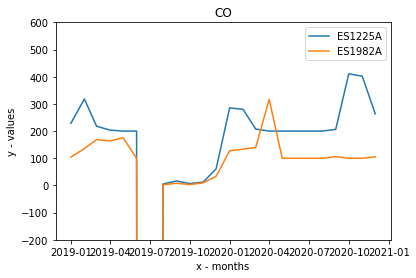

In [13]:
x1 = tmp['co'][tmp['co']['location'] == 'ES1225A']
x2 = tmp['co'][tmp['co']['location'] == 'ES1982A']

plt.plot(x1['time_window'], x1['value'], label='ES1225A')
plt.plot(x2['time_window'], x2['value'], label='ES1982A')

plt.xlabel('x - months')
plt.ylabel('y - values')

plt.ylim(-200, 600)
plt.title('CO')
#plt.rcParams["figure.figsize"] = (1,10)
plt.legend()

plt.show()
#tmp['co'][(tmp['co'].location == 'ES1225A')].plot(kind='line')

In [14]:
tmp['co'].plot(kind='line', x='time_window', y='avg(value)', title='Plot')

KeyError: 'avg(value)'

In [ ]:
tmp['co'].sort_values(by=['time_window'])